In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [62]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [63]:
# Load the training data
train_full_df = pd.read_csv('../data/train.csv').drop('Id', axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [64]:
# Check Square footage features to see what can be dropped
# GrLivArea = 1stFlrSF + 2ndFlrSF
sf_features_list = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
sf_df = train_full_df[sf_features_list]
sf_df.head()

,GrLivArea,1stFlrSF,2ndFlrSF,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
0,1710,856,854,856,706,0,150
1,1262,1262,0,1262,978,0,284
2,1786,920,866,920,486,0,434
3,1717,961,756,756,216,0,540
4,2198,1145,1053,1145,655,0,490


In [65]:
# cols_to_remove = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']
cols_to_remove = ['2ndFlrSF', 'TotalBsmtSF']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Create an EdaToolbox object

In [75]:
# Initialize the EdaToolbox
target_col = 'SalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [76]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [77]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [78]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [79]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [80]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [81]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.458296,0.457269,0.997850,0.808411,0.438234,0.438738,0.454177,0.372563
PowerTransformer,0.079379,0.058347,0.157959,0.157959,0.057236,0.057223,0.057962,0.053401
QuantileTransformer,0.369662,0.369474,1.013586,0.791327,0.362018,0.361977,0.367156,0.343568


In [82]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.422721,0.422694,1.103302,0.922071,0.440283,0.439069,0.434630,0.362610
PowerTransformer,0.054392,0.054367,0.171965,0.171965,0.054053,0.054063,0.055202,0.056041
QuantileTransformer,0.331671,0.331567,1.102105,0.881407,0.330971,0.332626,0.338124,0.352266


In [11]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [12]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.476075,0.475970,0.997850,0.824179,0.471866,0.472166,0.480465,0.390924
PowerTransformer,0.063827,0.063808,0.157959,0.157959,0.063236,0.063231,0.063567,0.057212
QuantileTransformer,0.405674,0.405616,1.013586,0.813565,0.402383,0.401733,0.404211,0.366428


In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.463651,0.463762,1.103302,0.935788,0.484601,0.483570,0.474841,0.354881
PowerTransformer,0.061688,0.061683,0.171965,0.171965,0.062490,0.062493,0.061782,0.060226
QuantileTransformer,0.381184,0.381146,1.102105,0.903826,0.386902,0.387838,0.381651,0.374075


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [83]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [84]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
Utilities,object,0.999315,AllPub,2,0,0.0,"Index(['AllPub', 'NoSeWa'], dtype='object', na..."
Street,object,0.995890,Pave,2,0,0.0,"Index(['Pave', 'Grvl'], dtype='object', name='..."
Condition2,object,0.989726,Norm,8,0,0.0,"Index(['Norm', 'Feedr', 'Artery', 'RRNn', 'Pos..."
RoofMatl,object,0.982192,CompShg,8,0,0.0,"Index(['CompShg', 'Tar&Grv', 'WdShngl', 'WdSha..."
Heating,object,0.978082,GasA,6,0,0.0,"Index(['GasA', 'GasW', 'Grav', 'Wall', 'OthW',..."


In [85]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [86]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.90)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__GrLivArea,0.697017,0.024828,0.137808,9.454675,0.159196,0.220180,1.101222
numerical__OverallQual,0.815044,0.027492,0.155521,4.174746,0.223213,0.008764,1.074513
ordinal_neighborhood__Neighborhood,0.740302,0.023270,0.164600,3.391108,0.213725,0.009944,0.987241
numerical__1stFlrSF,0.593533,0.011096,0.920492,7.289945,0.148434,0.229735,0.982798
ordinal_bsmtqual__BsmtQual,0.645938,0.006700,0.543016,4.274210,0.207153,0.111653,0.971444


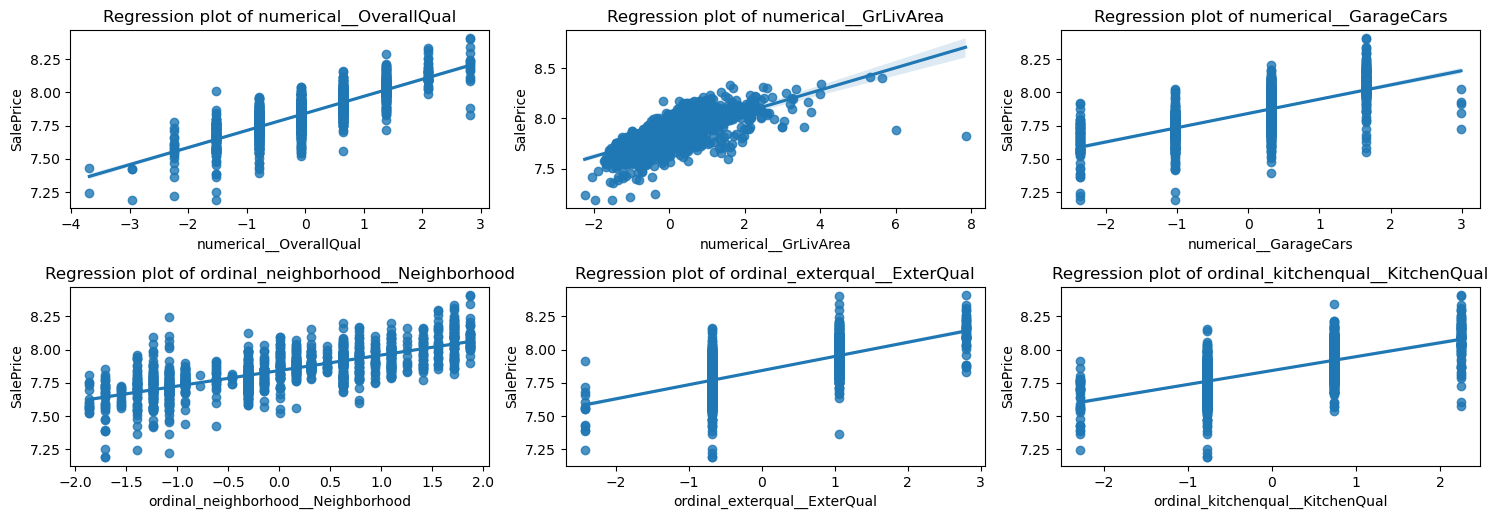

In [13]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.65)

## Perform unsupervised feature selection

Optimal number of features: 28


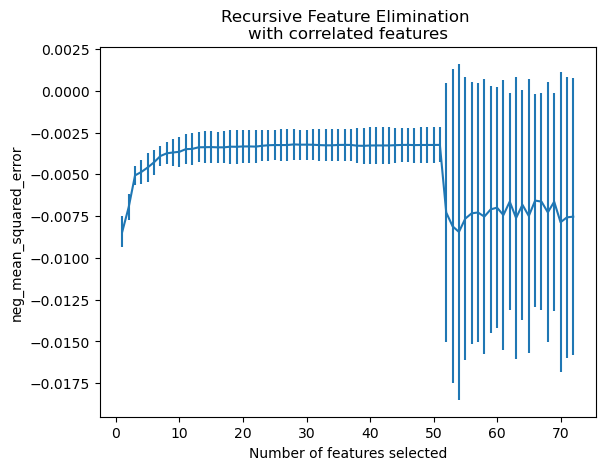

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-0.008418,0.000926,-0.007919,-0.010006,-0.008646,-0.007211,-0.008309,True,1,MSSubClass
1,-0.006968,0.000790,-0.005844,-0.007427,-0.007505,-0.006211,-0.007853,False,2,LotFrontage
2,-0.005064,0.000590,-0.004173,-0.005446,-0.005192,-0.004658,-0.005852,True,1,LotArea
3,-0.004858,0.000695,-0.003907,-0.005039,-0.004957,-0.004404,-0.005981,True,1,OverallQual
4,-0.004590,0.000875,-0.003385,-0.004897,-0.004464,-0.004167,-0.006035,True,1,OverallCond


In [87]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [88]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'BsmtFinSF1' '1stFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'TotRmsAbvGrd' 'GarageYrBlt' 'GarageCars' 'WoodDeckSF' 'ScreenPorch'
 'MSZoning' 'Neighborhood' 'Condition1' 'Foundation' 'BsmtQual'
 'BsmtExposure' 'HeatingQC' 'CentralAir' 'KitchenQual' 'Functional'
 'FireplaceQu' 'SaleCondition']


Optimal number of features: 28


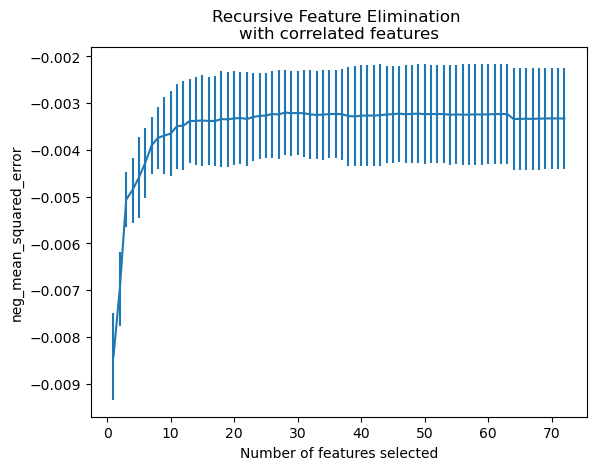

In [89]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [90]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'BsmtFinSF1' '1stFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'TotRmsAbvGrd' 'GarageYrBlt' 'GarageCars' 'WoodDeckSF' 'ScreenPorch'
 'MSZoning' 'Neighborhood' 'Condition1' 'Foundation' 'BsmtQual'
 'BsmtExposure' 'HeatingQC' 'CentralAir' 'KitchenQual' 'Functional'
 'FireplaceQu' 'SaleCondition']


In [91]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 28 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=28)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 28 features by forward sequential featureselection in 20.705 seconds
SFS Ridge Selected Features: ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'GarageCars', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'Foundation', 'BsmtQual', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'PoolQC', 'SaleCondition']


In [92]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_lr_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(12,
 ['MSZoning',
  'Neighborhood',
  'Condition1',
  'Foundation',
  'BsmtQual',
  'BsmtExposure',
  'HeatingQC',
  'CentralAir',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'SaleCondition'])

## Perform final EDA with selected features and ordinal columns

In [93]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtFinSF1', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd...
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['FireplaceQu']),
                                ('ordinal_salecondition',
                                 Pipeline(memory='named_steps',
                                          steps=[('SaleCondition',
                                                  OrdinalEncoder(categories=[['AdjLand',
                                                                              'Abnorml',
                                                                              'Family',
                                                                              'Alloca',
                                                                              'Normal',
                                                                              'Partial']],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['SaleCondition'])])

In [94]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 100.0 (R^2 score:  0.89)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__GrLivArea,0.697017,0.026887,0.074904,7.444887,0.227420,0.422616,1.373941
numerical__OverallQual,0.815044,0.029677,0.075554,3.656878,0.298602,0.053547,1.196870
numerical__YearBuilt,0.588037,0.006830,0.959676,5.479893,0.280175,0.297937,1.172979
numerical__TotRmsAbvGrd,0.532020,0.010477,0.810805,3.486635,0.169440,0.423420,1.135357
ordinal_neighborhood__Neighborhood,0.740302,0.023495,0.093168,3.106307,0.288618,0.067208,1.119623


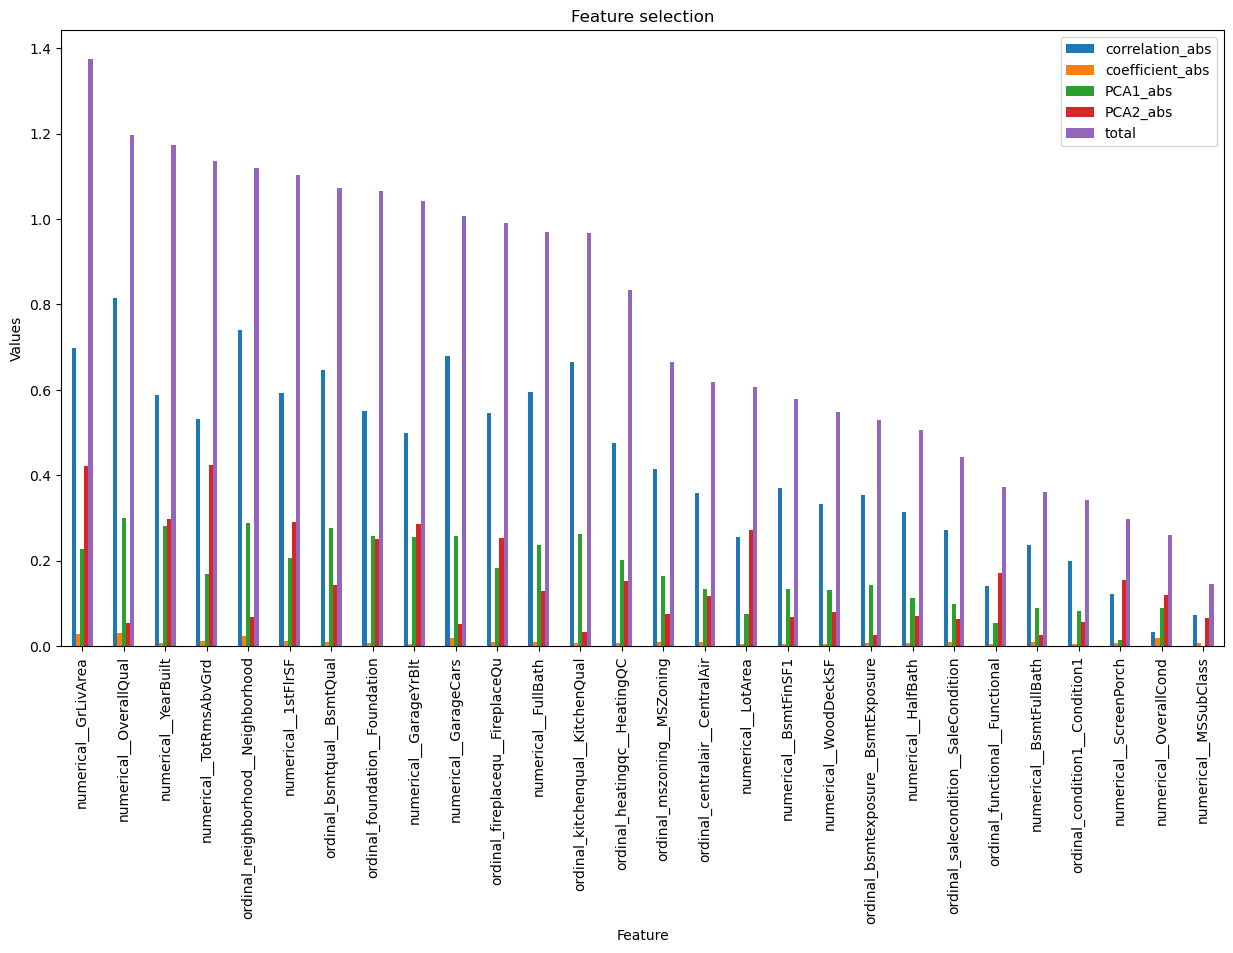

In [95]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [106]:
# Reload the data just to be safe
train_full_df = pd.read_csv('../data/train.csv')

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column='SalePrice')
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [107]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [108]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 80
Number scaled X cols: 28


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
Linear Regression,0.887244,0.002713,0.907679,0.897850,0.887643,0.044342,0.011682,"[7.764342838650248, 8.109340052947646, 7.70170..."
Ridge Regression,0.887243,0.002713,0.907665,0.897834,0.887643,0.044342,0.017480,"[7.7643166377887844, 8.109230316882835, 7.7017..."
LassoCV,0.887231,0.002719,0.907484,0.897635,0.887643,0.044342,0.103752,"[7.764080890681702, 8.109025306498305, 7.70145..."
ElasticNetCV,0.887231,0.002719,0.907482,0.897632,0.887643,0.044342,0.074988,"[7.764077241762419, 8.109009354829308, 7.70145..."
RidgeCV,0.886254,0.002783,0.905289,0.895206,0.887643,0.044342,0.017991,"[7.762366821450119, 8.10133033872101, 7.701938..."
HistGradientBoost,0.994176,0.003135,0.893315,0.881957,0.887643,0.044342,0.567885,"[7.752941314418586, 8.129863987262882, 7.66005..."


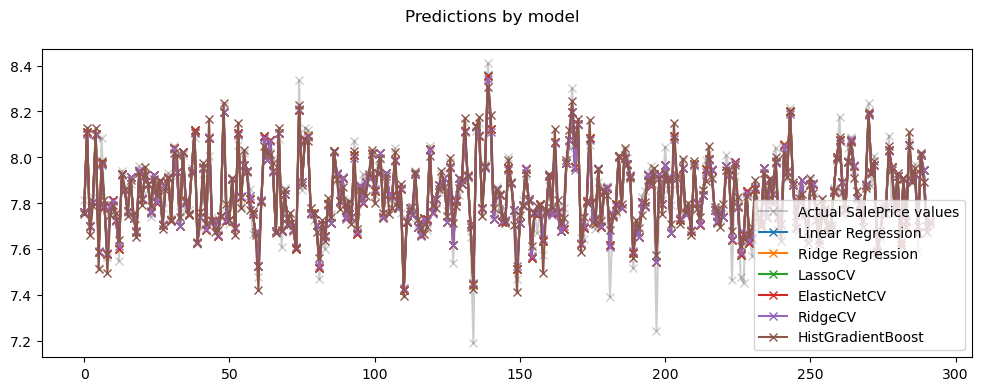

In [109]:
reg.plot_model_evaluations()

In [110]:
# Get the best model
reg.best_model_name

'Linear Regression'

## Now use the best model to predict on the test data

In [111]:
# Load test data
test_full_df = pd.read_csv('../data/test.csv')
test_full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [116]:
# Make predictions with LR
reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([117903.94137309, 151779.44876501, 173317.75081156, ...,
       167187.58329172, 118806.9324089 , 231357.98740887])

In [117]:
# Make predictions with HistGradientBoost
reg.best_model = model_dict['HistGradientBoost']
hgb_predictions = reg.predict(test_full_df)
hgb_predictions

array([124451.54786276, 165622.31880776, 192125.97481691, ...,
       153984.02621386, 124882.86718913, 221384.83925466])

In [118]:
# Prepare submission file for LR
new_submission_df = pd.DataFrame({
    'Id': test_full_df['Id'],
    'SalePrice': lr_predictions
})
new_submission_df.to_csv('../data/new_submission_lr.csv', index=False)
new_submission_df

,Id,SalePrice
0,1461,117903.941373
1,1462,151779.448765
2,1463,173317.750812
3,1464,198485.213610
4,1465,194771.509742
...,...,...
1454,2915,91966.143735
1455,2916,85799.363287
1456,2917,167187.583292
1457,2918,118806.932409


In [119]:
# Prepare submission file for HGB
new_submission_df = pd.DataFrame({
    'Id': test_full_df['Id'],
    'SalePrice': hgb_predictions
})
new_submission_df.to_csv('../data/new_submission_hgb.csv', index=False)
new_submission_df

,Id,SalePrice
0,1461,124451.547863
1,1462,165622.318808
2,1463,192125.974817
3,1464,192089.676984
4,1465,195406.206153
...,...,...
1454,2915,83281.160124
1455,2916,86385.135385
1456,2917,153984.026214
1457,2918,124882.867189
